# Exercise 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import warnings

warnings.filterwarnings("ignore")

# Load datasets
mnist = fetch_openml('mnist_784', version=1)
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)

clustering_algos = {
    "kmeans": KMeans,
    "dbscan": DBSCAN,
    "agglomerative": AgglomerativeClustering
}

reduction_methods = [None, "PCA", "UMAP"]

def reduce_dimensionality(data, method):
    if method == "PCA":
        return PCA(n_components=2, random_state=42).fit_transform(data)
    elif method == "UMAP":
        return umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42).fit_transform(data)
    else:
        return data

def run_dataset(data):
    for r in reduction_methods:
        data_red = reduce_dimensionality(data, r)
        for k, v in clustering_algos.items():
            model = v()
            if k == "dbscan":
                model.fit(data_red)
            else:
                labels = model.fit_predict(data_red)
            
            if len(np.unique(labels)) > 1:
                silhouette = silhouette_score(data_red, labels)
                print(f"Silhouette-Score für {k} mit {r}-Reduktion: {silhouette:.4f}")
            else:
                print(f"{k} mit {r}-Reduktion: Nur ein Cluster gefunden; Silhouette-Score nicht berechenbar.")

run_dataset(mnist.data[:10000])

# Niklas

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics import silhouette_score, davies_bouldin_score, jaccard_score
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load the Fashion-MNIST dataset
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# Limit the number of samples for faster execution
num_samples = 5000
x_train = x_train[:num_samples]
y_train = y_train[:num_samples]

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], -1)  # Flatten the images
x_train = StandardScaler().fit_transform(x_train)  # Normalize the data

# Initialize clustering algorithms
kmeans = KMeans(n_clusters=10, random_state=42)
dbscan = DBSCAN()
hierarchical = AgglomerativeClustering(n_clusters=10)

# Clustering without dimensionality reduction
print("Clustering without dimensionality reduction:")
algorithms = {'KMeans': kmeans, 'DBSCAN': dbscan, 'Hierarchical': hierarchical}

for name, algorithm in algorithms.items():
    # Fit the clustering algorithm
    labels = algorithm.fit_predict(x_train)

    # Evaluate the results
    try:
        silhouette = silhouette_score(x_train, labels)
        davies_bouldin = davies_bouldin_score(x_train, labels)
        print(f"{name}: Silhouette Score = {silhouette:.4f}, Davies-Bouldin Index = {davies_bouldin:.4f}")
    except Exception as e:
        print(f"{name}: Could not calculate scores due to {e}")

# Dimensionality reduction with PCA
pca = PCA(n_components=50)
x_pca = pca.fit_transform(x_train)

# Dimensionality reduction with UMAP
umap = UMAP(n_components=2, random_state=42)
x_umap = umap.fit_transform(x_train)

# Clustering after dimensionality reduction
print("\nClustering after dimensionality reduction (PCA):")
for name, algorithm in algorithms.items():
    labels = algorithm.fit_predict(x_pca)
    try:
        silhouette = silhouette_score(x_pca, labels)
        davies_bouldin = davies_bouldin_score(x_pca, labels)
        print(f"{name} (PCA): Silhouette Score = {silhouette:.4f}, Davies-Bouldin Index = {davies_bouldin:.4f}")
    except Exception as e:
        print(f"{name} (PCA): Could not calculate scores due to {e}")

print("\nClustering after dimensionality reduction (UMAP):")
for name, algorithm in algorithms.items():
    labels = algorithm.fit_predict(x_umap)
    try:
        silhouette = silhouette_score(x_umap, labels)
        davies_bouldin = davies_bouldin_score(x_umap, labels)
        print(f"{name} (UMAP): Silhouette Score = {silhouette:.4f}, Davies-Bouldin Index = {davies_bouldin:.4f}")
    except Exception as e:
        print(f"{name} (UMAP): Could not calculate scores due to {e}")


C:\Users\Niklas\miniconda3\envs\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4422102/4422102 [==============================] - 0s 0us/step
Clustering without dimensionality reduction:
KMeans: Silhouette Score = 0.1286, Davies-Bouldin Index = 2.0589
DBSCAN: Could not calculate scores due to Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Hierarchical: Silhouette Score = 0.1076, Davies-Bouldin Index = 2.1404


C:\Users\Niklas\miniconda3\envs\python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Clustering after dimensionality reduction (PCA):
KMeans (PCA): Silhouette Score = 0.1745, Davies-Bouldin Index = 1.7288
DBSCAN (PCA): Could not calculate scores due to Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Hierarchical (PCA): Silhouette Score = 0.1557, Davies-Bouldin Index = 1.8134

Clustering after dimensionality reduction (UMAP):
KMeans (UMAP): Silhouette Score = 0.5114, Davies-Bouldin Index = 0.6662
DBSCAN (UMAP): Silhouette Score = 0.5169, Davies-Bouldin Index = 0.5560
Hierarchical (UMAP): Silhouette Score = 0.4868, Davies-Bouldin Index = 0.7392


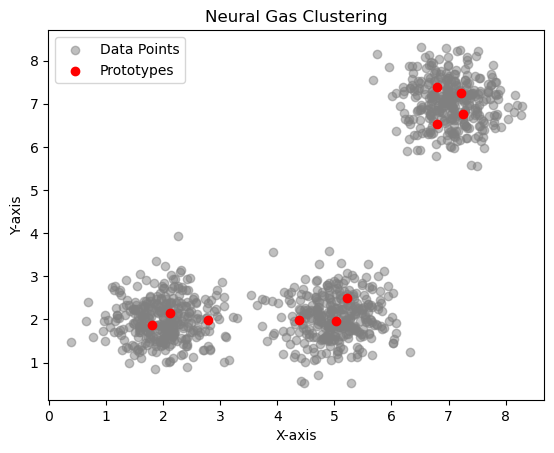

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic dataset (1000 points from three Gaussian distributions)
def generate_synthetic_data():
    np.random.seed(42)
    cluster_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(333, 2))
    cluster_2 = np.random.normal(loc=[7, 7], scale=0.5, size=(333, 2))
    cluster_3 = np.random.normal(loc=[5, 2], scale=0.5, size=(334, 2))
    return np.vstack([cluster_1, cluster_2, cluster_3])

# Neural Gas Algorithm
def neural_gas(data, n_prototypes, n_iterations, sigma, eta):
    np.random.seed(42)
    prototypes = np.random.uniform(np.min(data), np.max(data), (n_prototypes, data.shape[1]))

    for iteration in range(n_iterations):
        distances = np.linalg.norm(data[:, np.newaxis, :] - prototypes[np.newaxis, :, :], axis=2)
        ranking = np.argsort(distances, axis=1)

        for i in range(n_prototypes):
            # Update prototype positions
            rank = np.argsort(np.argsort(distances, axis=1), axis=1)[:, :, np.newaxis]
            update_factor = np.exp(-rank / sigma)
            numerator = np.sum(update_factor[:, i] * data, axis=0)
            denominator = np.sum(update_factor[:, i])
            prototypes[i] = numerator / denominator

    return prototypes

# Visualization of prototypes and clusters
def plot_clusters(data, prototypes):
    plt.scatter(data[:, 0], data[:, 1], c='gray', alpha=0.5, label='Data Points')
    plt.scatter(prototypes[:, 0], prototypes[:, 1], c='red', label='Prototypes')
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Neural Gas Clustering')
    plt.show()

# Main execution
data = generate_synthetic_data()
n_prototypes = 10
n_iterations = 100
sigma = 1.0
eta = 0.01

prototypes = neural_gas(data, n_prototypes, n_iterations, sigma, eta)
plot_clusters(data, prototypes)
